# Cut Labels

Cut Labels in LUSID are used to simplify timestamps and streamline the usage of LUSID in a global scenario across multiple timezones.

Instead of providing a date, time, and time zone in every transaction, LUSID can be provided with a date and a Cut Label - a user-defined tag describing a timezone and a specific local time in that time zone.

Cut Labels can be thought of as "Custom User Time" Labels, representing a daily cut-off times.

For example:

- UTC offset time: 2018-08-31T07:36:53.523415+01:00
- Cut label, assuming SingaporeClose has been configured: 2018-08-31NSingaporeClose

Find out more about Cut Labels in LUSID here:
[LUSID Knowledge Base: Cut Labels](https://support.lusid.com/what-are-cutlabels)

This example will cover how to set up and customise Cut Labels, and how to use these in LUSID. 

This example will outline how to:


1. Setting Up Cut Labels
	- 1.1. Creating Cut Labels
	- 1.2 Cut Label Details
	- 1.3. Deleting a Cut Label
2. Create a Transaction Portfolio
3. Add your Instrument Universe
4. Set your Initial Holdings
5. Get Output Transactions
6. Add your Transactions Throughout the Day
7. Retrieve your Transactions
8. Retrieve your Holdings
9. Delete Cut Labels and Portfolios

*First, run the cell below to import libraries and create the LUSID client to initialise our environment*

In [1]:
# Import LUSID
import lusid
import lusid.models as models
import lusid_sample_data as import_data
# Import Libraries
import pprint
from datetime import datetime, timedelta, time, date
import pytz
import uuid
import printer as prettyprint
from datetime import datetime
import pandas as pd
import numpy as np
import os
import json

# Authenticate our user and create our API client
client = import_data.authenticate_secrets()

print('LUSID Environment Initialised')
print('LUSID version : ', client.metadata.get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID version :  0.5.3086.0


### Initial Setup
The cell below contains a number of helper functions used throughout this notebook - these are not necessary for any of the methods demonstrated, but simplify the readability and usability of this module

In [2]:
# The following function creates a random alphanumeric code of 4 characters that can be appended to Ids
# and Names to ensure they remain unique throughout multiple runs of this example
def get_guid():
    return str(uuid.uuid4())[:4]

Later in this example we will create multiple cut labels in order to demonstrate their use. Note that for these cut labels we have used a range of different time zones. A full list of all accepted timezone names can be found here (under the column *"Zone ID"*): [IANA Time Zone Information](https://nodatime.org/TimeZones)

*Run the cell below to load a csv of cut label data*

In [3]:
# Load CSV file to create more cut labels from
data = pd.read_csv("data/dummy_cut_labels.csv")
data

,display_name,hours,minutes,time_zone
0,LondonOpen,7,0,GB
1,LondonMidday,12,0,GB
2,SingaporeOpen,9,0,Singapore
3,SingaporeMidday,12,0,Singapore
4,SingaporeClose,17,0,Singapore
5,NewYorkOpen,9,0,America/New_York
6,NewYorkMidday,12,0,America/New_York
7,NewYorkClose,17,0,America/New_York
8,DeleteMe,0,0,Europe/Berlin


## 1. Setting Up Cut Labels

### 1.1. Creating Cut Labels

We begin by creating a single cut label, named *"LondonClose"*, by defining the parameters of the cut label and upserting this into LUSID. We are also going to create a dictionary to store our codes, so that we can call them using *code["display_name"]*.

*Run the cell below to create a cut label and print its information*

In [4]:
# Create the time for the cut label
londonTime1 = models.CutLocalTime(hours=17, minutes=0)

# Create a dictionary to keep track of our cut label codes
code = {}

# Define the parameters of the cut label in a request
request = models.CutLabelDefinition(
    code="LondonClose-"+get_guid(), 
    description="London Closing Time, 5pm in UK", 
    display_name="LondonClose",
    cut_local_time=londonTime1,
    time_zone="GB")

# Add the codes of our cut labels to our dictionary
code[request.display_name] = request.code 

# Upsert the request to LUSID to create the cut label
result = client.cut_labels.create_cut_label_definition(
    create_request=request)

prettyprint.cut_label_response(result)

Cut Label Created
Display Name: LondonClose
Code: LondonClose-3bc5
Local Time: 17:00
Timezone: GB
Description: London Closing Time, 5pm in UK



Now we will create multiple more cut labels from the csv data by the same method, and then list the details of all of our existing cut labels.

These cut labels will represent the Open, Midday, and Closing times for 3 offices - one in London, one in Singapore, and one in New York, and we will later use these to make transactions. 

See below for a timeline of the working days of each office, compared to the London time along the bottom axis:

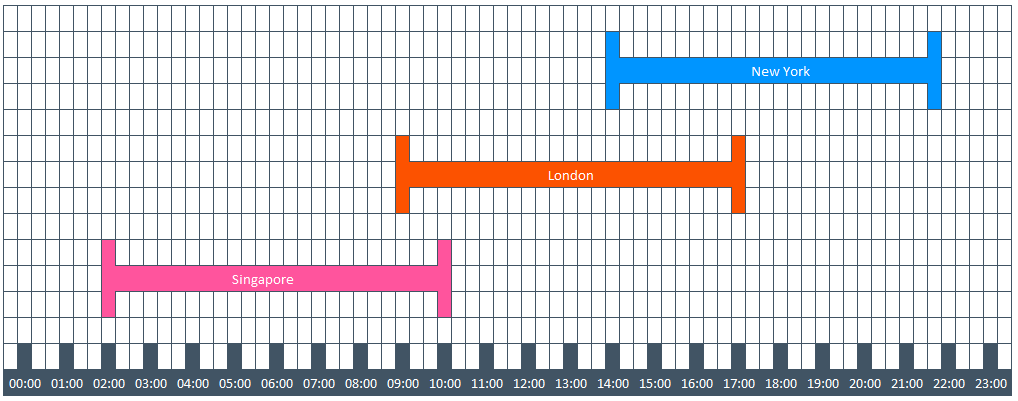

Making transactions across all of these timezones can get confusing, particularly when considering the holdings at different times and when each transaction occured in each time zone. Using our cut labels we will later demonstrate the bi-temporal features of LUSID to make this process simpler.  

Read more about bi-temporal data here: [LUSID Knowledge base: Bi-Temporal Data](https://support.lusid.com/what-is-bi-temporal-data)

*Run the cell below to create cut labels and print their information*

In [5]:
# Create cut labels from the loaded CSV data
for index, row in data.iterrows():
    print("Creating Cut Label ", index)
    guid = get_guid()
    # Create a request for our cut label
    request = models.CutLabelDefinition(
        code=row["display_name"]+"-"+guid,
        display_name=row["display_name"],
        description="",
        cut_local_time=models.CutLocalTime(
            hours=row["hours"], 
            minutes=row["minutes"]),
        time_zone=row["time_zone"])
    # Upsert the request to LUSID to create the cut label
    result = client.cut_labels.create_cut_label_definition(
        create_request=request)
    print("...")
    # Add the codes of our cut labels to our dictionary
    code[request.display_name] = request.code    

print("")

# List the details of all existing cut labels
response = client.cut_labels.list_cut_label_definitions()
prettyprint.list_cut_label_details(response)

Creating Cut Label  0
...
Creating Cut Label  1
...
Creating Cut Label  2
...
Creating Cut Label  3
...
Creating Cut Label  4
...
Creating Cut Label  5
...
Creating Cut Label  6
...
Creating Cut Label  7
...
Creating Cut Label  8
...

Existing Cut Labels:


,Display Name,Code,Local Time,Timezone,Description
0,SingaporeMidday,SingaporeMidday-cec4,12:00,Singapore,
1,NewYorkClose,NewYorkClose-9234,17:00,America/New_York,
2,DeleteMe,DeleteMe-3fc9,00:00,Europe/Berlin,
3,LondonOpen,LondonOpen-eb22,07:00,GB,
4,SingaporeOpen,SingaporeOpen-0936,09:00,Singapore,
5,NewYorkOpen,NewYorkOpen-3926,09:00,America/New_York,
6,SingaporeClose,SingaporeClose-49fd,17:00,Singapore,
7,NewYorkMidday,NewYorkMidday-ab46,12:00,America/New_York,
8,LondonClose,LondonClose-3bc5,17:00,GB,"London Closing Time, 5pm in UK"
9,LondonMidday,LondonMidday-c8d4,12:00,GB,


### 1.2 Cut Label Details

#### 1.2.1 Get Cut Label Details
We are now going to look closer at our LondonOpen cut label.

*Run the cell below to get details on the cut label "LondonClose"*

In [6]:
# First list the original details for the cut label we are going to change
details = client.cut_labels.get_cut_label_definition(
    code=code["LondonOpen"])
prettyprint.get_cut_label(details)

Cut Label Details:
Display Name: LondonOpen
Code: LondonOpen-eb22
Local Time: 7:00
Timezone: GB
Description: 



#### 1.2.2. Update a Cut Label
Looking closely, we can see that the Local Time for this cut label is wrong - it should be 9am. <br/>
We can now modify this, and we will add a description to this cut label

*Run the cell below to modify the details of the cut label*

In [7]:
# Modify London Close cut label time to 5:30pm
londonTime2 = models.CutLocalTime(hours=9, minutes=0)

request = models.CutLabelDefinition(
    description="London Opening Time, 9am in UK", 
    display_name="LondonOpen",
    cut_local_time=londonTime2,
    time_zone="GB")

response = client.cut_labels.update_cut_label_definition(
    code=code["LondonOpen"],
    update_request=request)

# Print the updated London Close cut label
prettyprint.update_cut_label(response)

Updated Cut Label:
Display Name: LondonOpen
Code: LondonOpen-eb22
Local Time: 9:00
Timezone: GB
Description: London Opening Time, 9am in UK



### 1.3. Deleting a Cut Label
When we created our cut labels, we also created one for an obsolete time, helpfully named *"DeleteMe"*.

We will now delete this cut label and list our cut labels again - DeleteMe has been deleted!

*Run the cell below to delete the cut label*

In [8]:
# Delete cut label "Delete Me"
client.cut_labels.delete_cut_label_definition(
    code=code["DeleteMe"])

# List the details of all existing cut labels
response = client.cut_labels.list_cut_label_definitions()
prettyprint.list_cut_label_details(response)

Existing Cut Labels:


,Display Name,Code,Local Time,Timezone,Description
0,LondonMidday,LondonMidday-c8d4,12:00,GB,
1,SingaporeClose,SingaporeClose-49fd,17:00,Singapore,
2,LondonClose,LondonClose-3bc5,17:00,GB,"London Closing Time, 5pm in UK"
3,NewYorkMidday,NewYorkMidday-ab46,12:00,America/New_York,
4,NewYorkOpen,NewYorkOpen-3926,09:00,America/New_York,
5,SingaporeMidday,SingaporeMidday-cec4,12:00,Singapore,
6,NewYorkClose,NewYorkClose-9234,17:00,America/New_York,
7,LondonOpen,LondonOpen-eb22,09:00,GB,"London Opening Time, 9am in UK"
8,SingaporeOpen,SingaporeOpen-0936,09:00,Singapore,


## 2. Create a Transaction Portfolio
We are now going to look at some example use cases for our cut labels. To do this we are going to need to create a portfolio to be used in all three of our offices, and in order to create a portfolio you will need to create a scope. Read more about scopes in the [LUSID Knowledge Base: Scopes](https://support.lusid.com/what-is-a-scope-in-lusid-and-how-is-it-used).

Once you have a scope, you can create a portfolio inside this scope. Every portfolio can be referenced by a unique code. Read more about portfolios in the [LUSID Knowledge Base: Portfolios](https://support.lusid.com/what-is-2).

For further usage of the create portfolio API call refer to the [LUSID API Docs: Create Portfolio](https://docs.lusid.com/#operation/CreatePortfolio).

> Note that currently the create portfolio API call does not support cut labels - make sure to check the api docs for *"date-time"* or *"dateorcutlabel"* for each parameter type

*Run the cell below to create your scope and portfolio*

In [9]:
# Create our portfolios from the loaded CSV data

# Create a scope for our portfolio
scope = 'portfolio_demo'

# Set the code of your portfolio
portfolio_code = 'Global-Strategies'+"-"+get_guid()

# Set the creation date of your portfolio
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)
created_portfolios = []

# Next we create a request for the portfolio
request = models.CreateTransactionPortfolioRequest(
    code=portfolio_code,
    display_name="Global Strategies Fund",
    base_currency="GBP",
    created=effective_date,
    description=None,
    corporate_action_source_id=None,
    accounting_method=None,
    sub_holding_keys=None,
    properties=None)
# And finally we can upsert the portfolio creation request to LUSID
result = client.transaction_portfolios.create_portfolio(
    scope=scope,
    create_request=request)
# Save the portfolio to a list for easy access later on
created_portfolios.append(result)

# Pretty print the response
prettyprint.portfolio_response(result)

Portfolio Created
Scope: portfolio_demo
Code: Global-Strategies-4439
Portfolio Effective From: 2018-01-01 00:00:00+00:00
Portfolio Created On: 2019-08-14 16:03:18.200676+00:00



We will now also define a function to format our cut label onto a date in a format readable to LUSID

> Date-times are usually in the form "2018-08-31T07:36:53.523415+01:00" 
>
>Cut labels are written in the form "2018-08-31NSingaporeClose"

In [10]:
# Defines a function to write the date and cut label in the format "YYYY-MM-DDN{cut_label_code}""
def cut_label_formatter(date, cut_label_code):
    return str(date) + "N" + cut_label_code

## 3. Add your Instrument Universe
We now want to make trades and take on holdings using our cut labels, but before we can do this we need to populate our instrument universe. In this case we are importing our instrument universe from a CSV file. 

Read more about instruments in LUSID in the [LUSID Knowledge Base: Instruments](https://support.lusid.com/what-is-an-instrument).

*Run the cell below to import your instrument universe*

In [11]:
instrument_universe = pd.read_csv('data/instruments.csv')
instrument_universe.head()

,instrument_name,client_internal,currency,isin,figi,exchange_code,country_issue,ticker,market_sector,security_type,coupon
0,Amazon_Nasdaq_AMZN,imd_34634534,USD,US0231351067,BBG000BVPXP1,UN,united_states_america,AMZN,equity,common_stock,NaN
1,Apple_Nasdaq_AAPL,imd_35345345,USD,US0378331005,BBG000B9XVV8,UN,united_states_america,AAPL,equity,common_stock,NaN
2,BP_LondonStockEx_BP,imd_43535553,GBP,GB0007980591,BBG000C05BD1,LN,united_kingdom,BP/,equity,common_stock,NaN
3,BurfordCapital_LondonStockEx_BUR,imd_43534356,GBP,GG00B4L84979,BBG000PN88Q7,LN,united_kingdom,BUR,equity,common_stock,NaN
4,EKFDiagnostics_LondonStockEx_EKF,imd_34535355,GBP,GB0031509804,BBG000BVNBN3,LN,united_kingdom,EKF,equity,common_stock,NaN


Now that you have the details for your instruments you can go ahead and create an instrument definition for each instrument. These can then be upserted into LUSID. Read about instrument definitions here [LUSID Knowledge Base: What is an Instrument?](https://support.lusid.com/what-is-an-instrument).

For further usage of the upsert instruments API call refer to the [LUSID API Docs: Upserting Instruments](https://docs.lusid.com/#operation/UpsertInstruments).

*Run the cell below to upsert your instruments into LUSID*

In [12]:
# Initialise your batch upsert request
batch_upsert_request = {}

# Using your instrument universe create your batch request
for index, instrument in instrument_universe.iterrows():

    # Specify the columns of your identifiers
    identifier_columns = [
            ('isin', 'Isin'), 
            ('figi', 'Figi'), 
            ('ticker', 'Ticker'),
            ('client_internal', 'ClientInternal')
    ]
    
    # Create your identifiers
    identifiers = {}
    for identifier in identifier_columns:
        identifiers[identifier[1]] = models.InstrumentIdValue(
            value=instrument[identifier[0]])
    
    # Build your request and add it to the dictionary
    batch_upsert_request[instrument['instrument_name']] = models.InstrumentDefinition(
        name=instrument['instrument_name'],
        identifiers=identifiers)
    
# Call LUSID to upsert your instrument defintions
instrument_response = client.instruments.upsert_instruments(
    requests=batch_upsert_request)

# Pretty print the response
prettyprint.instrument_response(instrument_response)

Instruments Successfully Upserted: 


,Instrument,ClientInternal ID,LUSID Instrument ID
0,Whitebread_LondonStockEx_WTB,imd_35349900,LUID_OEFL7HSH
1,Amazon_Nasdaq_AMZN,imd_34634534,LUID_5NE0UP7A
2,UKGiltTreasury_4.5_2034,imd_34534534,LUID_5YZ6CLQV
3,UKGiltTreasury_3.75_2021,imd_34643653,LUID_3JUBXF9T
4,EKFDiagnostics_LondonStockEx_EKF,imd_34535355,LUID_XD07K0SA
5,Glencore_LondonStockEx_GLEN,imd_34534555,LUID_MR6G7P77
6,UKGiltTreasury_2.0_2025,imd_34534536,LUID_ZTJQAA2N
7,Apple_Nasdaq_AAPL,imd_35345345,LUID_VNZ80E9W
8,WPP_LondonStockEx_WPP,imd_34536734,LUID_N601RM6G
9,USTreasury_6.875_2025,imd_34534539,LUID_IFWAHLX6


## 4. Set your Initial Holdings
Now that you have your instrument universe populated you can load your initial holdings into your portfolio. In this case you will import your holdings from a CSV file. 

*Run the cell below to import your take on balances*

In [13]:
holdings = pd.read_csv('data/demo-holdings.csv')
holdings.head()

,portfolio_code,instrument_name,quantity,price,currency,figi
0,Global-Strategies,GBP_Cash,8336000,1.000,GBP,NaN
1,Global-Strategies,Glencore_LondonStockEx_GLEN,905141,2.762,GBP,BBG001MM1KV4
2,Global-Strategies,Kingfisher_LondonStockEx_KGF,1362038,2.276,GBP,BBG000BKH1W6
3,Global-Strategies,UKGiltTreasury_2.0_2025,405589,106.637,GBP,BBG0088JSC32
4,Global-Strategies,UKGiltTreasury_3.5_2045,266169,134.433,GBP,BBG006N6HZM7


Now that you have imported your holdings you can add them to LUSID. You can do this by setting the holdings on a portfolio. 

Read more about how holdings are generated in LUSID here [LUSID Knowledge Base: The effect of holding adjustments](https://support.lusid.com/how-are-holdings-generate-by-lusid).

First we will need to set an effective date from which our holdings are recorded, which we will set as five days ago from the start of the day in our London office, using our *"LondonOpen"* cut label.

For further usage of the set holdings API call refer to the [LUSID API Docs: Set Holdings](https://docs.lusid.com/#operation/SetHoldings).

*Run the cell below to set our effective date and upsert your holdings into LUSID*

In [14]:
# Make the holdings effective date
holdings_effective_date = date.today() - timedelta(days=5)
holdings_cut_label_code = code["LondonOpen"]

holdings_effective_cut_label = cut_label_formatter(holdings_effective_date, holdings_cut_label_code)

print("Effective date: " + holdings_effective_cut_label + "\n")

# Iterate the portfolios in the holdings CSV, note in this case you only have one
for portfolio in holdings['portfolio_code'].unique():
    # Initialise a list to hold your adjustments
    holding_adjustments = []
    
    # Iterate over the holdings in each portfolio
    for index, holding in holdings.loc[holdings['portfolio_code'] == portfolio].iterrows():
        
        # Set your instrument identifiers based on whether or not instrument is cash
        if 'Cash' in holding['instrument_name']:
            identifier_key = 'Instrument/default/Currency'
            identifer = holding['instrument_name'].split('_')[0]
        else:
            identifier_key = 'Instrument/default/Figi'
            identifer = holding['figi']
            
        # Create your holding adjustment and append it to your list
        holding_adjustments.append(
            models.AdjustHoldingRequest(
                instrument_identifiers={
                    identifier_key: identifer},
                tax_lots=[
                    models.TargetTaxLotRequest(
                        units=holding['quantity'],
                        cost=models.CurrencyAndAmount(
                            amount=holding['quantity'] * holding['price'],
                            currency=holding['currency']),
                        portfolio_cost=holding['quantity'] * holding['price'],
                        price=holding['price'])
                ]
            )
        )
        
    # Call LUSID to set your initial holdings
    response = client.transaction_portfolios.set_holdings(
        scope=scope,
        code=portfolio_code,
        effective_at=holdings_effective_cut_label,
        holding_adjustments=holding_adjustments)

    # Pretty print our response from LUSID
    prettyprint.set_holdings_response(response, scope, portfolio)

Effective date: 2019-08-09NLondonOpen-eb22

Holdings Successfully Set for Portfolio
Scope: portfolio_demo
Code: Global-Strategies
Holdings Effective From: 2019-08-09 08:00:00+00:00
Holdings Created On: 2019-08-14 16:03:19.999469+00:00



## 5. Get Output Transactions
You can see how LUSID has adjusted the holdings of our portfolio to meet our initial holdings by generating the output transactions from the portfolio. You can read more about output transactions here [LUSID Knowledge Base: Output Transactions](https://support.lusid.com/what-is-an-output-transaction-in-lusid).

To build these transactions we need to set a start date and an end date - again we will use our London cut labels (LondonOpen and LondonClose) for these, as the holdings were set in the London office, and we will set our start and end dates to go with this cut label as 4 days either side of the effective date of our holdings.

For further usage of the build transactions API call refer to the [LUSID API Docs: Build Output Transactions](https://docs.lusid.com/#operation/BuildTransactions).

*Run the cell below to generate your output transactions*

In [15]:
# Set start date cut label
start_date_label = cut_label_formatter(
        holdings_effective_date-timedelta(days=4),
        code["LondonOpen"])
# Set end date cut label
end_date_label = end_date=cut_label_formatter(
        holdings_effective_date+timedelta(days=4),
        code["LondonClose"])

print("start date: " + start_date_label)
print("end date: " + end_date_label + "\n")

# Set our query parameters to build your transactions
query_params = models.TransactionQueryParameters(
    start_date=start_date_label,
    end_date=end_date_label,
    query_mode='TradeDate',
    show_cancelled_transactions=None)

# Call LUSID to build your output transactions
response = client.transaction_portfolios.build_transactions(
    scope=scope,
    code=portfolio_code,
    property_keys=['Instrument/default/Name'],
    parameters=query_params
)

# Pretty print your output transactions
prettyprint.output_transactions(response, scope, portfolio_code, ['Instrument/default/Name'])

start date: 2019-08-05NLondonOpen-eb22
end date: 2019-08-13NLondonClose-3bc5

Output Transactions for Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439



,Transaction ID,Transaction Type,Instrument/default/Name,Units,Price,Currency,Transaction Date,Settlement Date
0,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,Glencore_LondonStockEx_GLEN,905141.0,2.762,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
1,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,Kingfisher_LondonStockEx_KGF,1362038.0,2.276,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
2,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,UKGiltTreasury_2.0_2025,405589.0,106.637,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
3,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,UKGiltTreasury_3.5_2045,266169.0,134.433,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
4,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,UKGiltTreasury_3.75_2021,661713.0,108.126,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
5,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,UKGiltTreasury_4.5_2034,77481.0,140.572,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
6,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,USTreasury_2.00_2021,1440244.0,97.900,USD,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
7,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,BurfordCapital_LondonStockEx_BUR,853486.0,14.060,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
8,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,EKFDiagnostics_LondonStockEx_EKF,925925.0,0.270,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00
9,2019-08-09T08:00:00.0000000+00:00,AdjustmentIncrease,JustEat_LondonStockEx_JE,4860907.0,5.464,GBP,2019-08-09 08:00:00+00:00,2019-08-09 08:00:00+00:00


## 6. Add your Transactions Throughout the Day
Now that you have set your initial holdings you are ready to take on some transactions. You have made several trades over the last day in each office that you would like to add to LUSID. You will import these from a CSV file and split them up into the different regions. Note that this can also be done by importing 3 separate CSV files, or any other data store.

*Run the cell below to import your transactions*

In [16]:
daily_transactions = pd.read_csv('data/demo-transactions-2.csv')

daily_transactions_LDN =  daily_transactions.iloc[0:2,:]
daily_transactions_NY = daily_transactions.iloc[2:4,:]
daily_transactions_SG = daily_transactions.iloc[4:6,:]

daily_transactions.head()

,portfolio_code,transaction_id,instrument_name,transaction_description,transaction_type,transaction_units,transaction_price,transaction_currency,transaction_strategy,transaction_cost,figi
0,Global-Strategies,tid_329432525234324,Kingfisher_LondonStockEx_KGF,Equity Sale,Sell,325000,2.345,GBP,quantitativeSignal,762125.000,BBG000BKH1W6
1,Global-Strategies,tid_325452342424500,UKGiltTreasury_4.5_2034,Equity Purchase,Buy,10501,140.572,GBP,incomeRequirements,1476146.572,BBG0000D14P3
2,Global-Strategies,tid_234295929052090,UKGiltTreasury_3.75_2021,Equity Purchase,Buy,24000,109.126,GBP,incomeRequirements,2619024.000,BBG001KKJLR4
3,Global-Strategies,tid_234942982496001,USTreasury_2.00_2021,Equity Sale,Sell,57000,97.800,USD,internationalExposure,5574600.000,BBG00FN3B5K8
4,Global-Strategies,tid_121309590059995,BP_LondonStockEx_BP,Equity Purchase,Buy,50000,5.287,GBP,fundamentalAnalysis,264350.000,BBG000C05BD1


Now that we have imported our transactions we can upsert them into LUSID. 

We will upsert the transactions from each timezone using the respective cut labels to set our transaction and settlement dates.

Read more about transactions here [LUSID Knowledge Base: Transactions](https://support.lusid.com/what-is-a-transaction). 

For further usage of the upsert transactions API call refer to the [LUSID API Docs: Upsert Transactions](https://docs.lusid.com/#operation/UpsertTransactions).

*Run the cell below to upsert our London transactions into LUSID*

In [17]:
# Set your transaction and settlement dates
transaction_date = date.today()-timedelta(days=1)
settlement_date = date.today()+timedelta(days=1)

# Turn them into cut labels
transaction_cut_label = cut_label_formatter(transaction_date, code["LondonClose"])
settlement_cut_label = cut_label_formatter(settlement_date, code["LondonOpen"])

print("Transaction date: " + transaction_cut_label)
print("Settlement date: " + settlement_cut_label + "\n")

# Iterate over the portfolios in our transactions file, in this case only one
for portfolio in daily_transactions_LDN['portfolio_code'].unique():
    
    # Initialise a list to hold your transaction requests
    transactions = []
    
    # Iterate over the transactions in the portfolio
    for index, transaction in daily_transactions_LDN.loc[daily_transactions_LDN['portfolio_code'] == portfolio].iterrows():
        
        # Append your request to the list
        transactions.append(models.TransactionRequest(
            transaction_id=transaction['transaction_id'],
            type=transaction['transaction_type'],
            instrument_identifiers={
                'Instrument/default/Figi': transaction['figi']
            },
            transaction_date=transaction_cut_label,
            settlement_date=settlement_cut_label,
            units=transaction['transaction_units'],
            transaction_price=models.TransactionPrice(
                  price=transaction['transaction_price'],
                  type='Price'),
            total_consideration=models.CurrencyAndAmount(
              amount=transaction['transaction_cost'],
              currency=transaction['transaction_currency']),
             source='Default',
             transaction_currency=transaction['transaction_currency']))
        
    # Call LUSID to upsert your transactions for this portfolio
    response = client.transaction_portfolios.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transactions=transactions)
    
    # Print the response from LUSID using pretty formatting 
    prettyprint.transactions_response(
        response,
        scope,
        portfolio_code)

Transaction date: 2019-08-13NLondonClose-3bc5
Settlement date: 2019-08-15NLondonOpen-eb22

Transactions Successfully Upserted into Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439
Transactions Effective From: 2019-08-13 16:00:00+00:00
Transactions Created On: 2019-08-14 16:03:20.886959+00:00



*Run the cell below to upsert our New York transactions into LUSID*

In [18]:
# Set your transaction and settlement dates
transaction_date = date.today()-timedelta(days=1)
settlement_date = date.today()+timedelta(days=1)

# Turn them into cut labels
transaction_cut_label = cut_label_formatter(transaction_date, code["NewYorkClose"])
settlement_cut_label = cut_label_formatter(settlement_date, code["NewYorkOpen"])

print("Transaction date: " + transaction_cut_label)
print("Settlement date: " + settlement_cut_label + "\n")

# Iterate over the portfolios in our transactions file, in this case only one
for portfolio in daily_transactions_NY['portfolio_code'].unique():
    
    # Initialise a list to hold your transaction requests
    transactions = []
    
    # Iterate over the transactions in the portfolio
    for index, transaction in daily_transactions_NY.loc[daily_transactions_NY['portfolio_code'] == portfolio].iterrows():
        
        # Append your request to the list
        transactions.append(models.TransactionRequest(
            transaction_id=transaction['transaction_id'],
            type=transaction['transaction_type'],
            instrument_identifiers={
                'Instrument/default/Figi': transaction['figi']
            },
            transaction_date=transaction_cut_label,
            settlement_date=settlement_cut_label,
            units=transaction['transaction_units'],
            transaction_price=models.TransactionPrice(
                  price=transaction['transaction_price'],
                  type='Price'),
            total_consideration=models.CurrencyAndAmount(
              amount=transaction['transaction_cost'],
              currency=transaction['transaction_currency']),
             source='Default',
             transaction_currency=transaction['transaction_currency']))
        
    # Call LUSID to upsert your transactions for this portfolio
    response = client.transaction_portfolios.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transactions=transactions)
    
    # Print the response from LUSID using pretty formatting 
    prettyprint.transactions_response(
        response,
        scope,
        portfolio_code)

Transaction date: 2019-08-13NNewYorkClose-9234
Settlement date: 2019-08-15NNewYorkOpen-3926

Transactions Successfully Upserted into Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439
Transactions Effective From: 2019-08-13 21:00:00+00:00
Transactions Created On: 2019-08-14 16:03:21.281432+00:00



*Run the cell below to upsert our Singapore transactions into LUSID*

In [19]:
# Set your transaction and settlement dates
transaction_date = date.today()-timedelta(days=1)
settlement_date = date.today()+timedelta(days=1)

# Turn them into cut labels
transaction_cut_label = cut_label_formatter(transaction_date, code["SingaporeClose"])
settlement_cut_label = cut_label_formatter(settlement_date, code["SingaporeOpen"])

print("Transaction date: " + transaction_cut_label)
print("Settlement date: " + settlement_cut_label + "\n")

# Iterate over the portfolios in our transactions file, in this case only one
for portfolio in daily_transactions_SG['portfolio_code'].unique():
    
    # Initialise a list to hold your transaction requests
    transactions = []
    
    # Iterate over the transactions in the portfolio
    for index, transaction in daily_transactions_SG.loc[daily_transactions_SG['portfolio_code'] == portfolio].iterrows():
        
        # Append your request to the list
        transactions.append(models.TransactionRequest(
            transaction_id=transaction['transaction_id'],
            type=transaction['transaction_type'],
            instrument_identifiers={
                'Instrument/default/Figi': transaction['figi']
            },
            transaction_date=transaction_cut_label,
            settlement_date=settlement_cut_label,
            units=transaction['transaction_units'],
            transaction_price=models.TransactionPrice(
                  price=transaction['transaction_price'],
                  type='Price'),
            total_consideration=models.CurrencyAndAmount(
              amount=transaction['transaction_cost'],
              currency=transaction['transaction_currency']),
             source='Default',
             transaction_currency=transaction['transaction_currency']))
        
    # Call LUSID to upsert your transactions for this portfolio
    response = client.transaction_portfolios.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transactions=transactions)
    
    # Print the response from LUSID using pretty formatting 
    prettyprint.transactions_response(
        response,
        scope,
        portfolio_code)

Transaction date: 2019-08-13NSingaporeClose-49fd
Settlement date: 2019-08-15NSingaporeOpen-0936

Transactions Successfully Upserted into Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439
Transactions Effective From: 2019-08-13 09:00:00+00:00
Transactions Created On: 2019-08-14 16:03:21.909831+00:00



## 7. Retrieve your Transactions
So now we've made our transactions, but because they all occurred at different times in different time zones, it can be difficult to figure out when transactions from one time zone occurred in another.

We can visualise our transactions happening as below, with the transactions for each region shown in green:

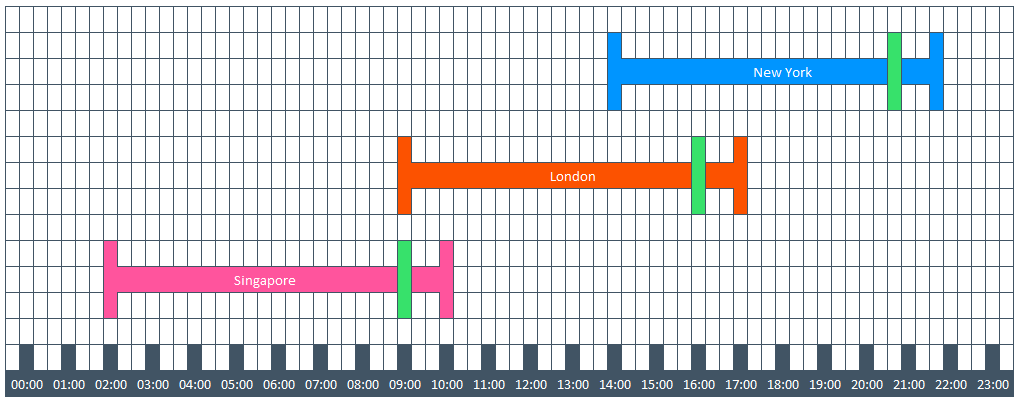

We can now go back and look at the transactions countained in our portfolio, and we can get these transactions over a given interval of effective time. Therefore we will look at the transactions occuring between the opening and closing times at each of our offices, using our cut labels.

From the above timeline, we should expect to see just the Singapore transactions over the Singapore working day, the Singapore and London transactions in London, and the London and New York transactions in New York. The good news is - LUSID works this all out for us!

For further usage of the get transactions API call refer to the [LUSID API Docs: Get Transactions](https://docs.lusid.com/#operation/GetTransactions).
                                                                                                   
*Run the cell below to get your transactions throughout the day in London*

In [20]:
london_open_formatted = cut_label_formatter(transaction_date, code["LondonOpen"])
london_close_formatted = cut_label_formatter(transaction_date, code["LondonClose"])

# Call LUSID to get your transactions made between these cut labels
response = client.transaction_portfolios.get_transactions(
    scope=scope,
    code=portfolio_code,
    from_transaction_date=london_open_formatted, 
    to_transaction_date=london_close_formatted)

# Pretty print the response
print("Transactions occuring during London working day: \n")
prettyprint.get_transactions_response(
    response,
    scope,
    portfolio_code,
    [])

Transactions occuring during London working day: 

Transactions Retrieved from Portfolio
Scope:  portfolio_demo
Code:  Global-Strategies-4439 



,Transaction ID,Transaction Type,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Units,Price,Currency,Transaction Date
0,tid_121309590059995,Buy,Global-Strategies-4439,portfolio_demo,50000.0,5.287,GBP,2019-08-13 09:00:00+00:00
1,tid_124319009950924,Sell,Global-Strategies-4439,portfolio_demo,-28000.0,98.100,USD,2019-08-13 09:00:00+00:00
2,tid_329432525234324,Sell,Global-Strategies-4439,portfolio_demo,325000.0,2.345,GBP,2019-08-13 16:00:00+00:00
3,tid_325452342424500,Buy,Global-Strategies-4439,portfolio_demo,10501.0,140.572,GBP,2019-08-13 16:00:00+00:00


*Run the cell below to get your transactions throughout the day in New York*

In [21]:
NY_open_formatted = cut_label_formatter(transaction_date, code["NewYorkOpen"])
NY_close_formatted = cut_label_formatter(transaction_date, code["NewYorkClose"])

# Call LUSID to get your transactions made between these cut labels
response = client.transaction_portfolios.get_transactions(
    scope=scope,
    code=portfolio_code,
    from_transaction_date=NY_open_formatted, 
    to_transaction_date=NY_close_formatted)

# Pretty print the response
print("Transactions occuring during New York working day: \n")
prettyprint.get_transactions_response(
    response,
    scope,
    portfolio_code,
    [])

Transactions occuring during New York working day: 

Transactions Retrieved from Portfolio
Scope:  portfolio_demo
Code:  Global-Strategies-4439 



,Transaction ID,Transaction Type,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Units,Price,Currency,Transaction Date
0,tid_329432525234324,Sell,Global-Strategies-4439,portfolio_demo,325000.0,2.345,GBP,2019-08-13 16:00:00+00:00
1,tid_325452342424500,Buy,Global-Strategies-4439,portfolio_demo,10501.0,140.572,GBP,2019-08-13 16:00:00+00:00
2,tid_234295929052090,Buy,Global-Strategies-4439,portfolio_demo,24000.0,109.126,GBP,2019-08-13 21:00:00+00:00
3,tid_234942982496001,Sell,Global-Strategies-4439,portfolio_demo,57000.0,97.800,USD,2019-08-13 21:00:00+00:00


*Run the cell below to get your transactions throughout the day in Singapore*

In [22]:
singapore_open_formatted = cut_label_formatter(transaction_date, code["SingaporeOpen"])
singapore_close_formatted = cut_label_formatter(transaction_date, code["SingaporeClose"])

# Call LUSID to get your transactions made between these cut labels
response = client.transaction_portfolios.get_transactions(
    scope=scope,
    code=portfolio_code,
    from_transaction_date=singapore_open_formatted, 
    to_transaction_date=singapore_close_formatted)

# Pretty print the response
print("Transactions occuring during Singapore working day: \n")
prettyprint.get_transactions_response(
    response,
    scope,
    portfolio_code,
    [])

Transactions occuring during Singapore working day: 

Transactions Retrieved from Portfolio
Scope:  portfolio_demo
Code:  Global-Strategies-4439 



,Transaction ID,Transaction Type,Transaction/default/SourcePortfolioId,Transaction/default/SourcePortfolioScope,Units,Price,Currency,Transaction Date
0,tid_121309590059995,Buy,Global-Strategies-4439,portfolio_demo,50000.0,5.287,GBP,2019-08-13 09:00:00+00:00
1,tid_124319009950924,Sell,Global-Strategies-4439,portfolio_demo,-28000.0,98.100,USD,2019-08-13 09:00:00+00:00


## 8. Retrieve your Holdings
We can see how these transactions have affected your holdings by trying to retrieve the holdings of your portfolio. 

Again, it can be quite difficult to see how our transactions have changed our initial holdings at different times in each time zone, but again LUSID does the hard work for us - all we need to do is provide the cut label for the time at which we would like to retrieve our holdings. 

We will retrieve the holdings at the closing time for each office using our cut labels.

For further usage of the get holdings API call refer to the [LUSID API Docs: Get Holdings](https://docs.lusid.com/#operation/GetHoldings).

*Run the cells below to get our holdings from our portfolio at the end of the day in London*

In [23]:
# Get holdings in London
result = client.transaction_portfolios.get_holdings(
    scope=scope,
    code=portfolio_code,
    property_keys=['Instrument/default/Name'],
    effective_at=london_close_formatted)

print("Effective at: " + london_close_formatted + "\n")
prettyprint.holdings_response(result, scope, portfolio_code)

Effective at: 2019-08-13NLondonClose-3bc5

Holdings for Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439



,Instrument/default/Name,Units,Cost,Currency,Unsettled Transaction Id,Settlement Date
0,Glencore_LondonStockEx_GLEN,9.051410e+05,2.499999e+06,GBP,-,-
1,Kingfisher_LondonStockEx_KGF,1.037038e+06,2.360298e+06,GBP,-,-
2,UKGiltTreasury_2.0_2025,4.055890e+05,4.325079e+07,GBP,-,-
3,UKGiltTreasury_3.5_2045,2.661690e+05,3.578190e+07,GBP,-,-
4,UKGiltTreasury_3.75_2021,6.617130e+05,7.154838e+07,GBP,-,-
5,UKGiltTreasury_4.5_2034,8.798200e+04,1.236781e+07,GBP,-,-
6,USTreasury_2.00_2021,1.468244e+06,1.437467e+08,USD,-,-
7,BurfordCapital_LondonStockEx_BUR,8.534860e+05,1.200001e+07,GBP,-,-
8,EKFDiagnostics_LondonStockEx_EKF,9.259250e+05,2.499998e+05,GBP,-,-
9,JustEat_LondonStockEx_JE,4.860907e+06,2.656000e+07,GBP,-,-


*Run the cells below to get our holdings from our portfolio at the end of the day in New York*

In [24]:
# Get holdings in New York
result = client.transaction_portfolios.get_holdings(
    scope=scope,
    code=portfolio_code,
    property_keys=['Instrument/default/Name'],
    effective_at=NY_close_formatted)

print("Effective at: " + NY_close_formatted + "\n")
prettyprint.holdings_response(result, scope, portfolio_code)

Effective at: 2019-08-13NNewYorkClose-9234

Holdings for Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439



,Instrument/default/Name,Units,Cost,Currency,Unsettled Transaction Id,Settlement Date
0,Glencore_LondonStockEx_GLEN,9.051410e+05,2.499999e+06,GBP,-,-
1,Kingfisher_LondonStockEx_KGF,1.037038e+06,2.360298e+06,GBP,-,-
2,UKGiltTreasury_2.0_2025,4.055890e+05,4.325079e+07,GBP,-,-
3,UKGiltTreasury_3.5_2045,2.661690e+05,3.578190e+07,GBP,-,-
4,UKGiltTreasury_3.75_2021,6.857130e+05,7.416740e+07,GBP,-,-
5,UKGiltTreasury_4.5_2034,8.798200e+04,1.236781e+07,GBP,-,-
6,USTreasury_2.00_2021,1.411244e+06,1.381662e+08,USD,-,-
7,BurfordCapital_LondonStockEx_BUR,8.534860e+05,1.200001e+07,GBP,-,-
8,EKFDiagnostics_LondonStockEx_EKF,9.259250e+05,2.499998e+05,GBP,-,-
9,JustEat_LondonStockEx_JE,4.860907e+06,2.656000e+07,GBP,-,-


*Run the cells below to get our holdings from our portfolio at the end of the day in Singapore*

In [25]:
# Get holdings in Singapore
result = client.transaction_portfolios.get_holdings(
    scope=scope,
    code=portfolio_code,
    property_keys=['Instrument/default/Name'],
    effective_at=singapore_close_formatted)

print("Effective at: " + singapore_close_formatted + "\n")
prettyprint.holdings_response(result, scope, portfolio_code)

Effective at: 2019-08-13NSingaporeClose-49fd

Holdings for Portfolio
Scope: portfolio_demo
Code: Global-Strategies-4439



,Instrument/default/Name,Units,Cost,Currency,Unsettled Transaction Id,Settlement Date
0,Glencore_LondonStockEx_GLEN,905141.0,2.499999e+06,GBP,-,-
1,Kingfisher_LondonStockEx_KGF,1362038.0,3.099998e+06,GBP,-,-
2,UKGiltTreasury_2.0_2025,405589.0,4.325079e+07,GBP,-,-
3,UKGiltTreasury_3.5_2045,266169.0,3.578190e+07,GBP,-,-
4,UKGiltTreasury_3.75_2021,661713.0,7.154838e+07,GBP,-,-
5,UKGiltTreasury_4.5_2034,77481.0,1.089166e+07,GBP,-,-
6,USTreasury_2.00_2021,1468244.0,1.437467e+08,USD,-,-
7,BurfordCapital_LondonStockEx_BUR,853486.0,1.200001e+07,GBP,-,-
8,EKFDiagnostics_LondonStockEx_EKF,925925.0,2.499998e+05,GBP,-,-
9,JustEat_LondonStockEx_JE,4860907.0,2.656000e+07,GBP,-,-


## 9. Delete Cut Labels and Portfolios
Finally, we will delete all of our existing cut labels and our portfolio, in order to tidy up our LUSID environment from this example and allowing it to be run again in its entirety.

*Run the cells below to clear up your LUSID environment*

In [26]:
# Deletes all cut labels
for body in client.cut_labels.list_cut_label_definitions().values:
    client.cut_labels.delete_cut_label_definition(
        code=body.code)

# Check they've been deleted
prettyprint.list_cut_labels(client.cut_labels.list_cut_label_definitions())

# Delete portfolio
delete = client.portfolios.delete_portfolio(
    scope=scope, 
    code=portfolio_code)

Existing Cut Labels:
